In [1]:
import sys
sys.path.append("../")
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import torch
import torch.nn as nn
import numpy as np

from HyperSINDy import Net
from baseline import Trainer
from library_utils import Library
from Datasets import SyntheticDataset
from other import init_weights, set_random_seed

from exp_utils import get_equations, log_equations

import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

sns.set()

In [2]:
def load_model(device, z_dim, poly_order, include_constant,
               noise_dim, hidden_dim, stat_size, batch_size,
               num_hidden, batch_norm, cp_path):

    torch.cuda.set_device(device=device)
    device = torch.cuda.current_device()

    library = Library(n=z_dim, poly_order=poly_order, include_constant=include_constant)

    net = Net(library, noise_dim=noise_dim, hidden_dim=hidden_dim,
              statistic_batch_size=stat_size,
              num_hidden=num_hidden, batch_norm=batch_norm).to(device)

    cp = torch.load(cp_path, map_location="cuda:" + str(device)) 
    net.load_state_dict(cp['model'])
    net.to(device)
    net = net.eval()
    
    return net, library, device

# Load Model

In [3]:
SEED = 5281998

In [4]:
data_folder = "../data/"
model = "HyperSINDy"
dt = 0.01
hidden_dim = 128
stat_size = 250
num_hidden = 5
z_dim = 10
adam_reg = 1e-2
gamma_factor = 0.999
poly_order = 3
include_constant = True
device = 2
batch_norm = False
noise_dim = 20
runs = "../runs/lorenz96"
library = Library(n=z_dim, poly_order=poly_order, include_constant=include_constant)

In [5]:
net, library, device = load_model(device, z_dim, poly_order, include_constant,
                                  noise_dim, hidden_dim, stat_size, stat_size,
                                  num_hidden, batch_norm, runs + "/cp_1.pt")

In [6]:
def sample_trajectory(net, library, device, x0, batch_size=10, dt=1e-2, ts=10000):
    set_random_seed(SEED)
    zc = torch.from_numpy(x0).type(torch.FloatTensor).to(device).unsqueeze(0)
    zc = zc.expand(batch_size, -1)
    zs = []
    for i in range(ts):
        coefs = net.get_masked_coefficients(batch_size=batch_size, device=device)        
        lib = net.library.transform(zc).unsqueeze(1)
        zc = zc + torch.bmm(lib, coefs).squeeze(1) * dt
        zs.append(zc)
    zs = torch.stack(zs, dim=0)
    zs = torch.transpose(zs, 0, 1)
    return zs.detach().cpu().numpy()

In [7]:
timesteps = 2500

In [8]:
x_test = np.load("../data/lorenz96/scale-10.0/x_test_1.npy")
x0_test = x_test[0]

In [9]:
samples = sample_trajectory(net, library, device, x0_test, batch_size=5, dt=dt, ts=timesteps)

In [10]:
samples

array([[[  8.0301   ,   8.741432 ,   8.397555 , ...,   6.66441  ,
           6.944002 ,   8.811516 ],
        [  8.119965 ,   8.780919 ,   8.291051 , ...,   6.410085 ,
           7.0391765,   8.84948  ],
        [  8.411586 ,   8.630801 ,   8.139651 , ...,   6.3407555,
           7.3024006,   8.9919   ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[  7.994615 ,   8.744105 ,   8.211902 , ...,   6.683387 ,
           6.9814963,   8.789377 ],
        [  7.9857526,   8.658554 ,   8.150716 , ...,   6.5491815,
           7.2000613,   8.779866 ],
        [  8.033795 ,   8.573318 ,   7.8224955, ...,   6.409371 ,
           7.304965 ,   8.701574 ],
        ...,
        [ -1.4067831,  24.251251 ,   3.6394248, ...,  

In [11]:
idx = 3

In [12]:
sample = samples[idx]

In [13]:
t = np.array([np.linspace(0, timesteps * dt, timesteps) for _ in range(z_dim)]).T

In [14]:
spatial = np.array([np.arange(1, z_dim + 1, 1) for _ in range(timesteps)])

In [15]:
def plot_both(spatial, t, sample, test, figsize, fname, cmap):
    vmin = min(np.min(sample), np.min(test))
    vmax = max(np.max(sample), np.max(test))
    fig, axes = plt.subplots(2, 1, figsize=figsize, dpi=500)
    mesh1 = axes[0].pcolormesh(t, spatial, test, cmap=cmap, vmin=vmin, vmax=vmax)
    mesh2 = axes[1].pcolormesh(t, spatial, sample, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.subplots_adjust(right=0.8)
    colorbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(mesh1, cax=colorbar_ax)
    cbar.ax.tick_params(labelsize=20)
    axes[0].set_xticks([])
    axes[0].tick_params(axis='both', which='major', labelsize=20)
    axes[1].tick_params(axis='both', which='major', labelsize=20)
    plt.savefig(fname)
    plt.show()
    plt.close()

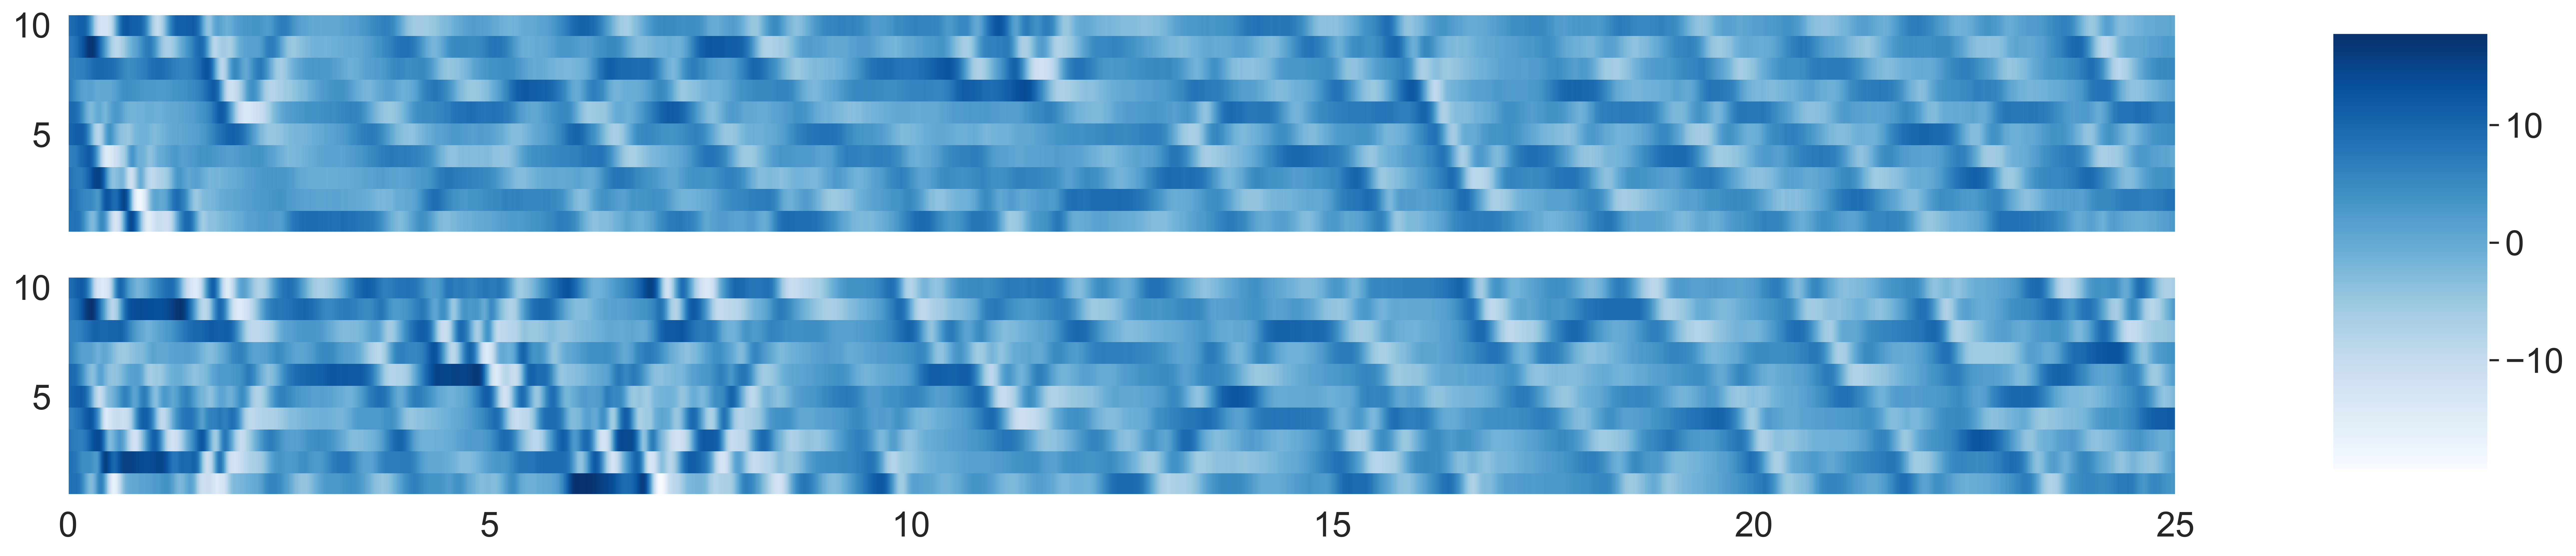

In [16]:
plot_both(spatial, t, sample, x_test[0:timesteps], (25, 5), "../results/fig4.png", "Blues")

In [17]:
def plot_single(spatial, t, traj, figsize, fname, cmap, vmin, vmax):
    fig = plt.figure(figsize=figsize, dpi=500)
    mesh = plt.pcolormesh(t, spatial, traj, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig(fname)
    plt.show()
    plt.close()

In [18]:
vmin = min(np.min(sample), np.min(x_test))
vmax = max(np.max(sample), np.max(x_test))

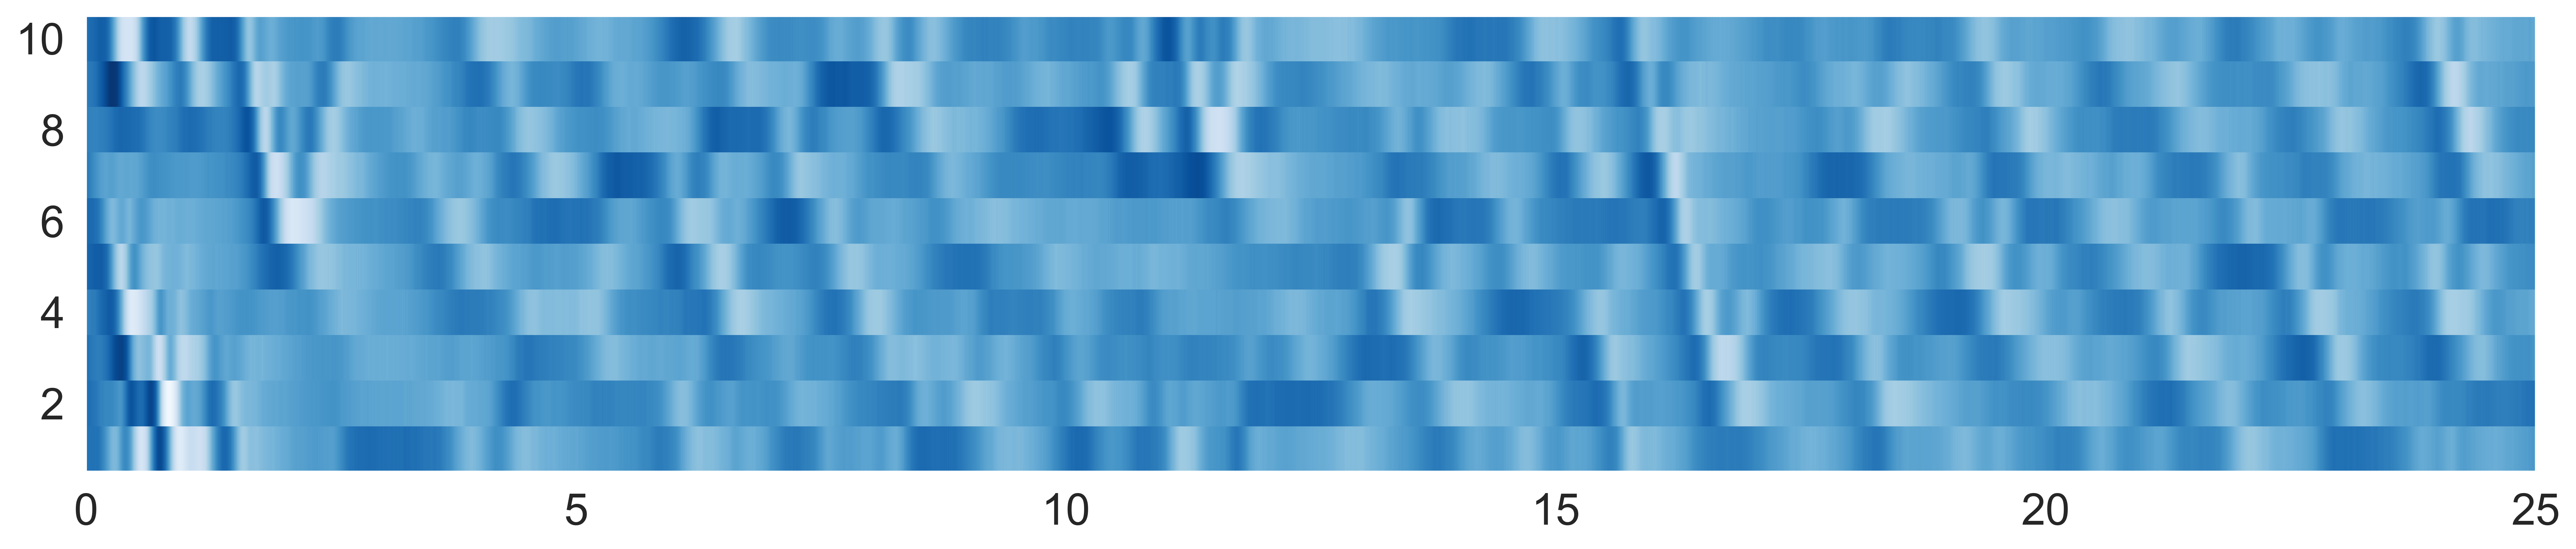

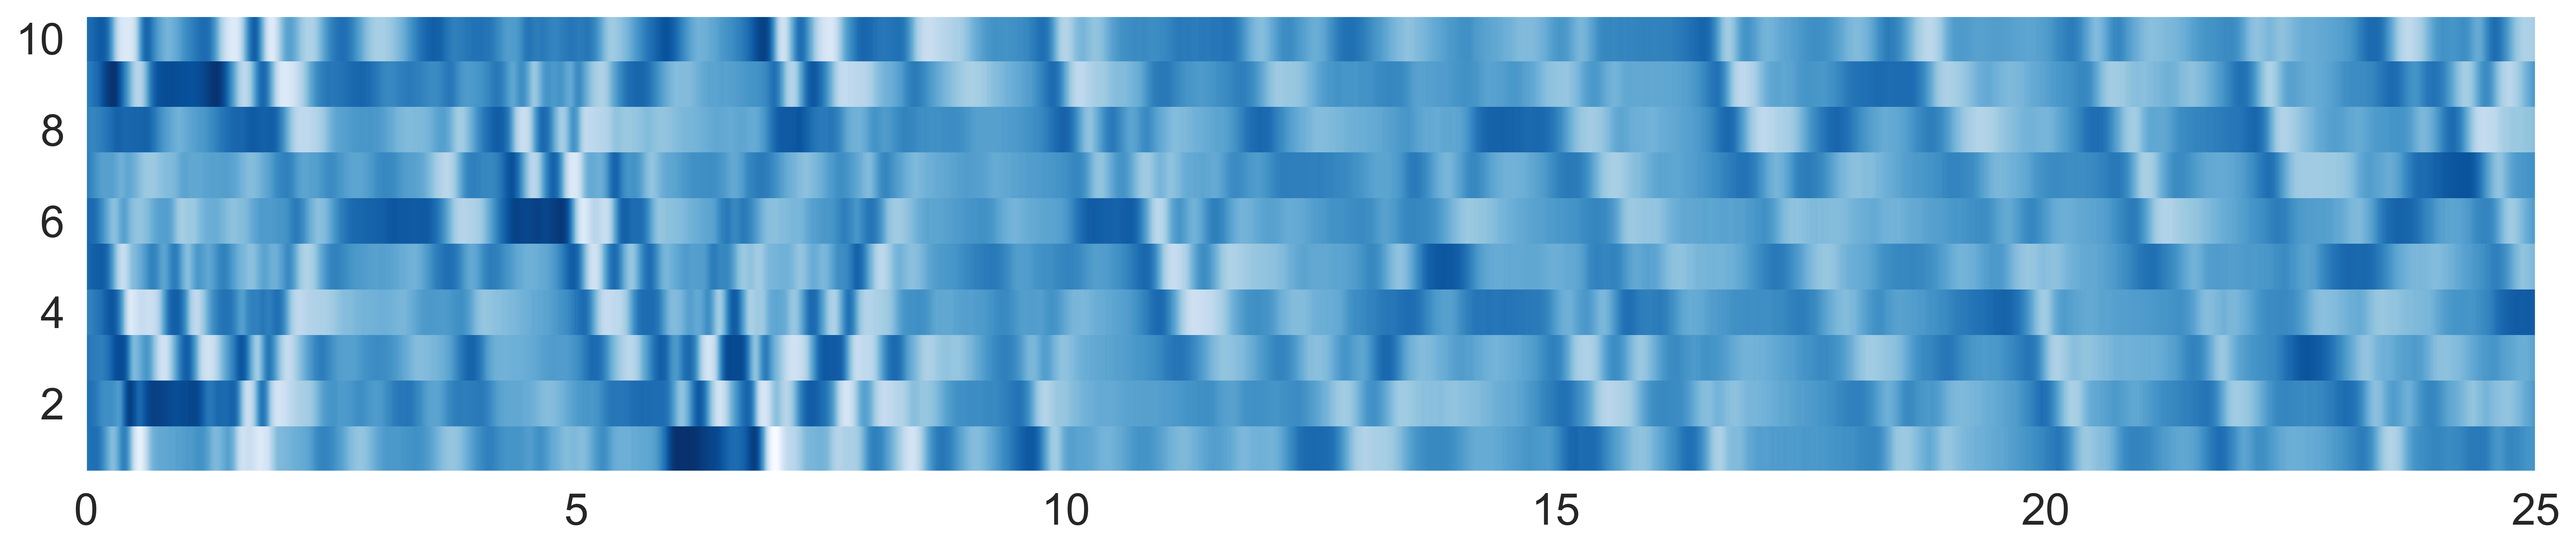

In [19]:
plot_single(spatial, t, x_test[0:timesteps], (20, 3.75), "../results/fig4_test.png", "Blues", vmin, vmax)
plot_single(spatial, t, sample, (20, 3.75), "../results/fig4_sample.png", "Blues", vmin, vmax)